In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def dict_to_matrix(dict, matrix_size):
    matrix = np.zeros((matrix_size, matrix_size))
    for source, targets in dict.items():
        source_idx = int(source.split('_')[0])
        for target, value in targets.items():
            target_idx = int(target.split('_')[0])
            matrix[source_idx, target_idx] = value
    return matrix

In [4]:
def create_alluvial_data(df, time_cols):
    """
    Convert DataFrame with community classifications to alluvial input format
    for multiple timepoints
    
    Parameters:
    df: DataFrame with community classifications
    time_cols: list of column names representing timepoints
    
    Returns:
    list: Array of dictionaries ready for alluvial.plot
    """
    results = []
    
    # Create transition matrices for consecutive timepoints
    for i in range(len(time_cols) - 1):
        current_time = time_cols[i]
        next_time = time_cols[i + 1]
        
        result = {}
        source_communities = sorted(df[current_time].unique())
        target_communities = sorted(df[next_time].unique())
        
        # Initialize the nested dictionary
        for source in source_communities:
            source_label = f"{source}_{current_time}"
            result[source_label] = {}
            for target in target_communities:
                target_label = f"{target}_{next_time}"
                result[source_label][target_label] = 0.0
        
        # Count transitions between communities
        for source in source_communities:
            source_label = f"{source}_{current_time}"
            source_group = df[df[current_time] == source]
            
            for target in target_communities:
                target_label = f"{target}_{next_time}"
                count = len(source_group[source_group[next_time] == target])
                if count > 0:
                    result[source_label][target_label] = float(count)
        
        # Remove empty source communities
        result = {k: v for k, v in result.items() 
                 if any(val > 0 for val in v.values())}
        result = dict_to_matrix(result, len(source_communities))
        results.append(result)
    
    return results


In [ ]:
def create_alluvial_data_with_intermediates(df, time_cols):
    """
    Convert DataFrame with community classifications to alluvial input format
    including indirect transitions through intermediate communities
    
    Parameters:
    df: DataFrame with community classifications
    time_cols: list of 3 column names representing timepoints
    
    Returns:
    tuple: (direct_transitions, intermediate_transitions)
        - direct_transitions: list of direct transition matrices
        - intermediate_transitions: list of transition matrices through each T2 community
    """
    if len(time_cols) != 3:
        raise ValueError("This function requires exactly 3 timepoints")
    
    # Get direct transitions (T1->T2 and T2->T3)
    direct_transitions = create_alluvial_data(df, time_cols)
    
    # Get indirect transitions through each T2 community
    intermediate_transitions = []
    t2_communities = sorted(df[time_cols[1]].unique())
    
    for t2_community in t2_communities:
        # Filter nodes that passed through this T2 community
        intermediate_nodes = df[df[time_cols[1]] == t2_community]
        
        result = {}
        source_communities = sorted(intermediate_nodes[time_cols[0]].unique())
        target_communities = sorted(intermediate_nodes[time_cols[2]].unique())
        
        # Initialize the nested dictionary
        for source in source_communities:
            source_label = f"{source}_{time_cols[0]}"
            result[source_label] = {}
            for target in target_communities:
                target_label = f"{target}_{time_cols[2]}"
                result[source_label][target_label] = 0.0
        
        # Count transitions
        for source in source_communities:
            source_label = f"{source}_{time_cols[0]}"
            source_group = intermediate_nodes[intermediate_nodes[time_cols[0]] == source]
            
            for target in target_communities:
                target_label = f"{target}_{time_cols[2]}"
                count = len(source_group[source_group[time_cols[2]] == target])
                if count > 0:
                    result[source_label][target_label] = float(count)
        
        # Remove empty source communities
        result = {k: v for k, v in result.items() 
                 if any(val > 0 for val in v.values())}
        result = dict_to_matrix(result, len(df[time_cols[0]].unique()))
        intermediate_transitions.append((t2_community, result))
    
    return direct_transitions, intermediate_transitions

In [20]:
# Create a sample data frame with 20 rows which occupy different communities at t1, t2, and t3
import pandas as pd
import numpy as np
import random

# Create a sample data frame with 24 rows
df = pd.DataFrame(np.arange(0,48), columns=['id'])

# Create transitions with controlled randomization
# First assign T1 based on id ranges
df['T1'] = np.floor(df['id']/16).astype(int)
df['T2'] = df.apply(lambda row: row['T1'] if random.random() < .7 else random.randint(0, 2), axis=1)
df['T3'] = df.apply(lambda row: row['T2'] if random.random() < .7 else random.randint(0, 2), axis=1)

direct_transitions, intermediate_transitions = create_alluvial_data_with_intermediates(df, ['T1', 'T2', 'T3'])
print(direct_transitions)
print(intermediate_transitions)

t1_t2_matrix = direct_transitions[0]
t2_t3_matrix = direct_transitions[1]


[array([[11.,  3.,  2.],
       [ 0., 13.,  3.],
       [ 2.,  1., 13.]]), array([[11.,  1.,  1.],
       [ 1., 15.,  1.],
       [ 3.,  1., 14.]])]
[(np.int64(0), array([[11.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  1.]])), (np.int64(1), array([[ 0.,  3.,  0.],
       [ 1., 11.,  1.],
       [ 0.,  1.,  0.]])), (np.int64(2), array([[0., 0., 2.],
       [0., 0., 3.],
       [3., 1., 9.]]))]


In [ ]:
direct_trans_matrices = [direct_transitions]
inter_trans_matrices = [[matrix for _, matrix in intermediate_transitions]]
direct_trans_figs = []
inter_trans_figs = []

[[array([[11.,  3.,  2.],
         [ 0., 13.,  3.],
         [ 2.,  1., 13.]]),
  array([[11.,  1.,  1.],
         [ 1., 15.,  1.],
         [ 3.,  1., 14.]])]]

: 

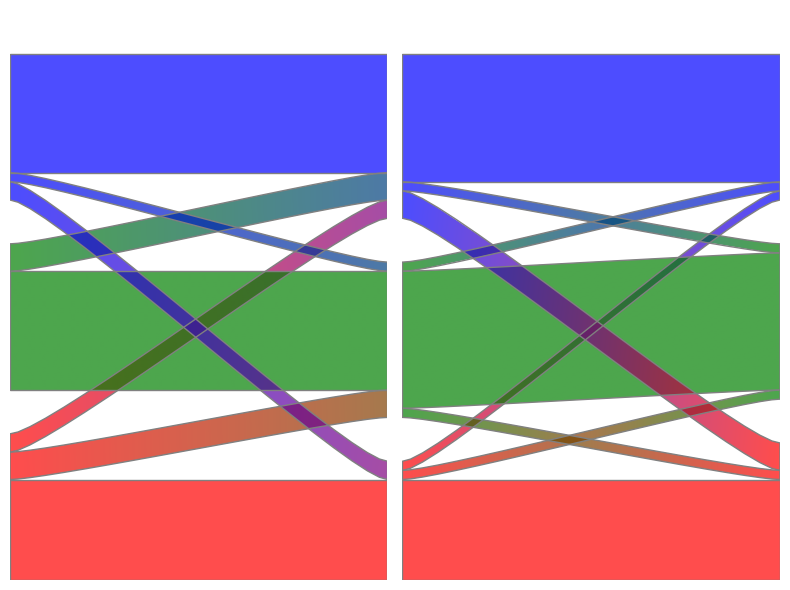

In [ ]:
import importlib
import my_alluvial
importlib.reload(my_alluvial)
from my_alluvial import create_flow_diagram

# Close the initial unused figure
plt.close()

# Create figure with gridspec
fig = plt.figure(figsize=(8, 6))
gs = plt.GridSpec(1, 2, figure=fig)

# Create subplot with 2 horizontal axes using gridspec
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# Create flow diagrams on each axis
colors = ['red', 'green', 'blue']
_,colors_out_1 = create_flow_diagram(t1_t2_matrix, colors_in=colors, colors_out=colors, interp_frac=0.5, ax=ax1)
_,colors_out_2 = create_flow_diagram(t2_t3_matrix, colors_in=colors, colors_out=colors, ax=ax2)

# Remove spacing between subplots
plt.subplots_adjust(wspace=0)

# Adjust layout to prevent overlapping
plt.tight_layout()



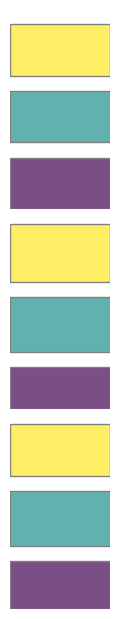

In [ ]:
def create_self_map_fig(df, time_col, ax):
    communities = sorted(df[time_col].unique())
    matrix_size = len(communities)
    matrix = np.zeros((matrix_size, matrix_size))
    
    # Fill diagonal with counts (self-mapping)
    for i, community in enumerate(communities):
        count = len(df[df[time_col] == community])
        matrix[i, i] = float(count)
    
    ax, _ = create_flow_diagram(matrix, ax=ax)
    plt.tight_layout(pad=0, w_pad=0, h_pad=0)
    return matrix, ax

# Create figure with dynamic height based on number of timepoints
timepoints = ['T1', 'T2', 'T3']
fig = plt.figure(figsize=(1, 2*len(timepoints)))
gs = fig.add_gridspec(len(timepoints), 1)

# Initialize arrays to store results
axes = []
matrices = []

# Create subplots and store data for each timepoint
for i, time_col in enumerate(timepoints):
    ax = fig.add_subplot(gs[i])
    matrix, ax = create_self_map_fig(df, time_col, ax=ax)
    axes.append(ax)
    matrices.append(matrix)


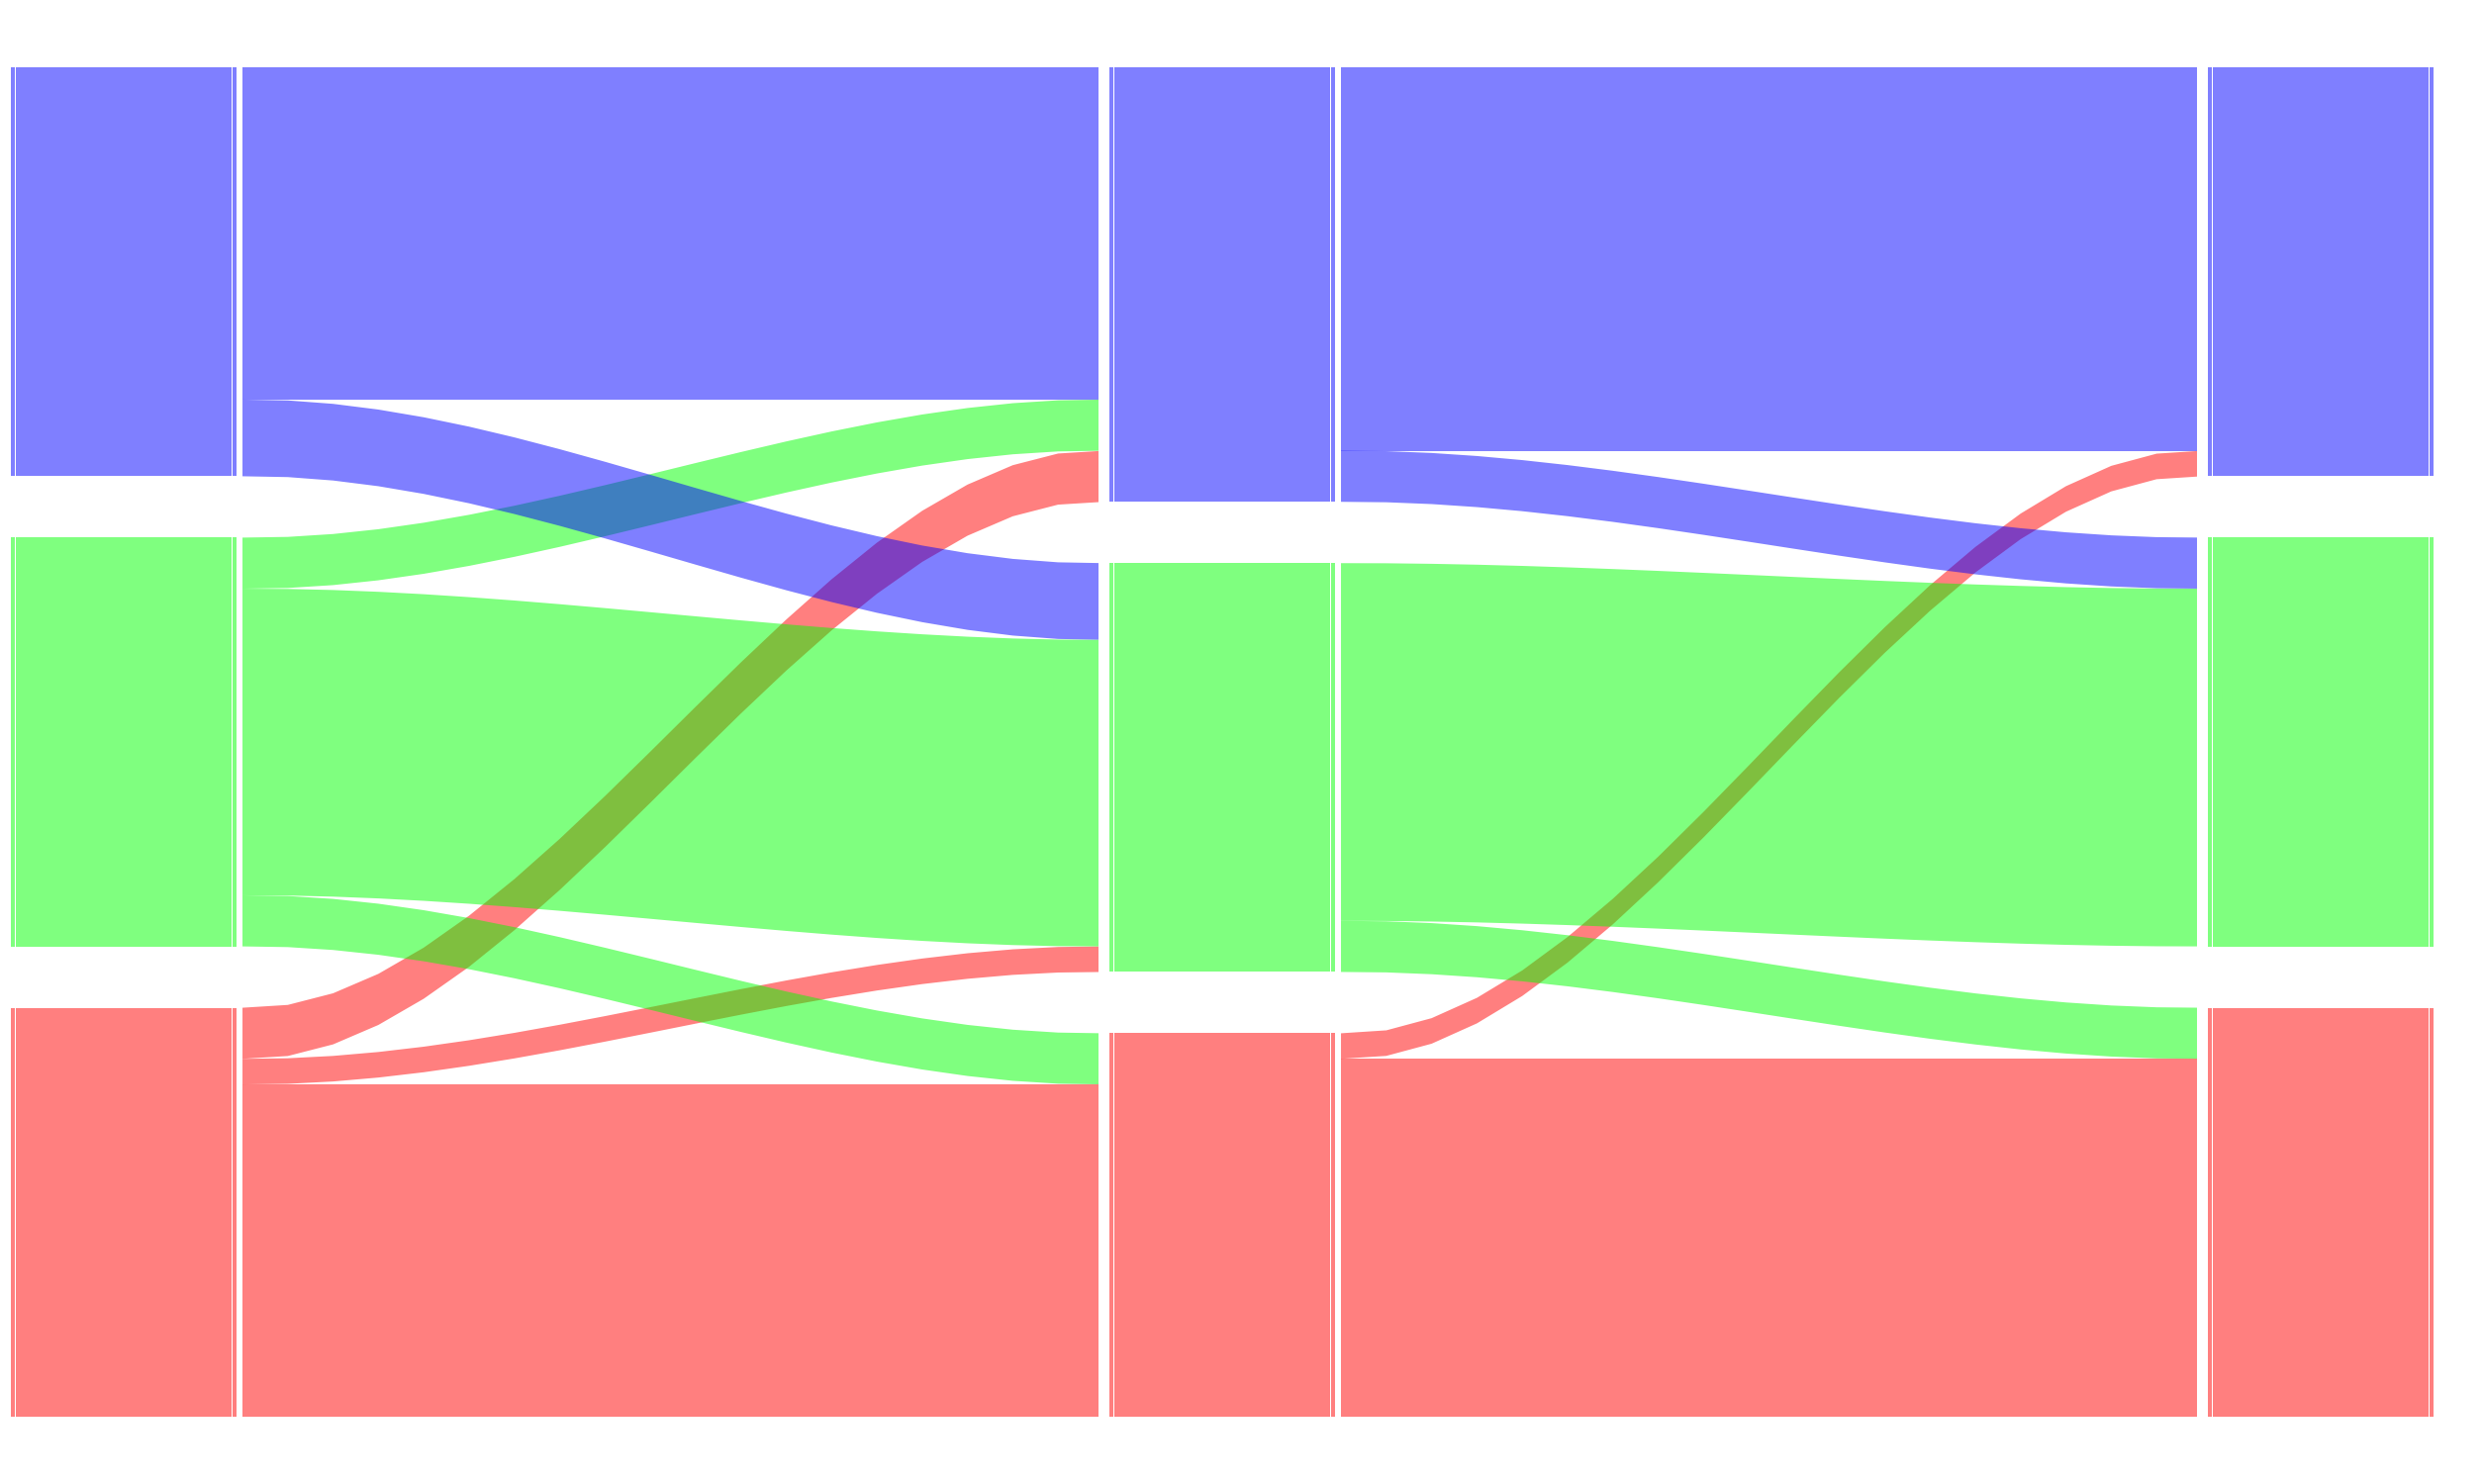

In [36]:
# Load all images
images = [Image.open(x) for x in ['alluvial_T1.png', 'alluvial12.png', 'alluvial_T2.png', 'alluvial23.png', 'alluvial_T3.png']]

# Crop the transition plots (alluvial12 and alluvial23)
crop_left = 60
crop_right = 60
images[1] = images[1].crop((crop_left, 0, images[1].width - crop_right, images[1].height))
images[3] = images[3].crop((crop_left, 0, images[3].width - crop_right, images[3].height))


# Get dimensions
widths, heights = zip(*(i.size for i in images))
total_width = sum(widths)
max_height = max(heights)

# Create new image with white background
new_im = Image.new('RGBA', (total_width, max_height), 'white')

# Paste images horizontally
x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]-10

new_im.save('first-order composite.png')
display(new_im)

In [37]:
def plot_and_save_alluvial_transitions(transitions_list, prefix='alluvial13', colors=['#FF0000', '#00FF00', '#0000FF']):
    # Calculate total flows for each transition
    def calculate_total_flow(transition_dict):
        return sum(sum(targets.values()) for targets in transition_dict.values())
    
    total_flows = [calculate_total_flow(trans) for trans in transitions_list]
    
    # Plot and save each transition
    for i, transition in enumerate(transitions_list):
        ax = alluvial.plot(transition, colors=colors, v_gap_frac=0.0)
        plt.tight_layout(pad=0, w_pad=0, h_pad=0)
        plt.savefig(f'{prefix}_{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close(ax.figure)
    
    return total_flows

# Extract transitions from intermediate_transitions
t1_t3_transitions = [
    intermediate_transitions[2][1],
    intermediate_transitions[1][1],
    intermediate_transitions[0][1]
]

# Plot and get total flows
total_flows = plot_and_save_alluvial_transitions(t1_t3_transitions)

images = [Image.open(x) for x in ['alluvial13_0.png', 'alluvial13_1.png', 'alluvial13_2.png']]
widths, heights = zip(*(i.size for i in images))
max_width = max(widths)//3
# Calculate base height using the maximum flow
tot_flow = sum(total_flows)
base_height = int(sum(heights) //3*.91)

# Calculate proportional heights
proportional_heights = [int(base_height * (flow / tot_flow)) for flow in total_flows]

new_im = Image.new('RGB', (max_width, base_height+65), 'white')

y_offset = 50
i = 0
for im, prop_height in zip(images, proportional_heights):
    # Resize image maintaining aspect ratio but using proportional height
    aspect_ratio = im.size[0] / im.size[1]
    new_height = prop_height
    new_width = int(new_height * aspect_ratio)
    resized_im = im.resize((max_width, new_height))
    
    # Convert to RGBA if not already
    if resized_im.mode != 'RGBA':
        resized_im = resized_im.convert('RGBA')
    
    # Create gradient mask
    pixels = resized_im.load()
    for x in range(max_width):
        gradient_factor = 1.33*max(0,x / max_width -.25)  # 0 to 1 from left to right
        for y in range(new_height):
            r, g, b, a = pixels[x, y]
            if r+g+b>=700:
                continue
            if i == 2:  # Red gradient
                r = min(255, int(r + (255 - r) * gradient_factor))
                g = max(130, int(g * (1 - gradient_factor)))
                b = max(130, int(b * (1 - gradient_factor)))
            elif i == 1:  # Green gradient
                r = max(130, int(r * (1 - gradient_factor)))
                g = min(255, int(g + (255 - g) * gradient_factor))
                b = max(130, int(b * (1 - gradient_factor)))
            else:  # Blue gradient
                r = max(130, int(r * (1 - gradient_factor)))
                g = max(130, int(g * (1 - gradient_factor)))
                b = min(255, int(b + (255 - b) * gradient_factor))
            pixels[x, y] = (r, g, b, a)
    new_im.paste(resized_im, (0, y_offset))
    y_offset += new_height+20
    i+=1

new_im.save('intermediate.jpg')
# display(new_im)
# display(new_im)

In [38]:
intermediate_transitions

[(np.int64(0),
  {'0_T1': {'0_T3': 12.0, '2_T3': 1.0}, '1_T1': {'0_T3': 2.0, '2_T3': 0.0}}),
 (np.int64(1),
  {'0_T1': {'0_T3': 1.0, '1_T3': 0.0},
   '1_T1': {'0_T3': 1.0, '1_T3': 11.0},
   '2_T1': {'0_T3': 0.0, '1_T3': 3.0}}),
 (np.int64(2),
  {'0_T1': {'1_T3': 0.0, '2_T3': 2.0},
   '1_T1': {'1_T3': 0.0, '2_T3': 2.0},
   '2_T1': {'1_T3': 2.0, '2_T3': 11.0}})]

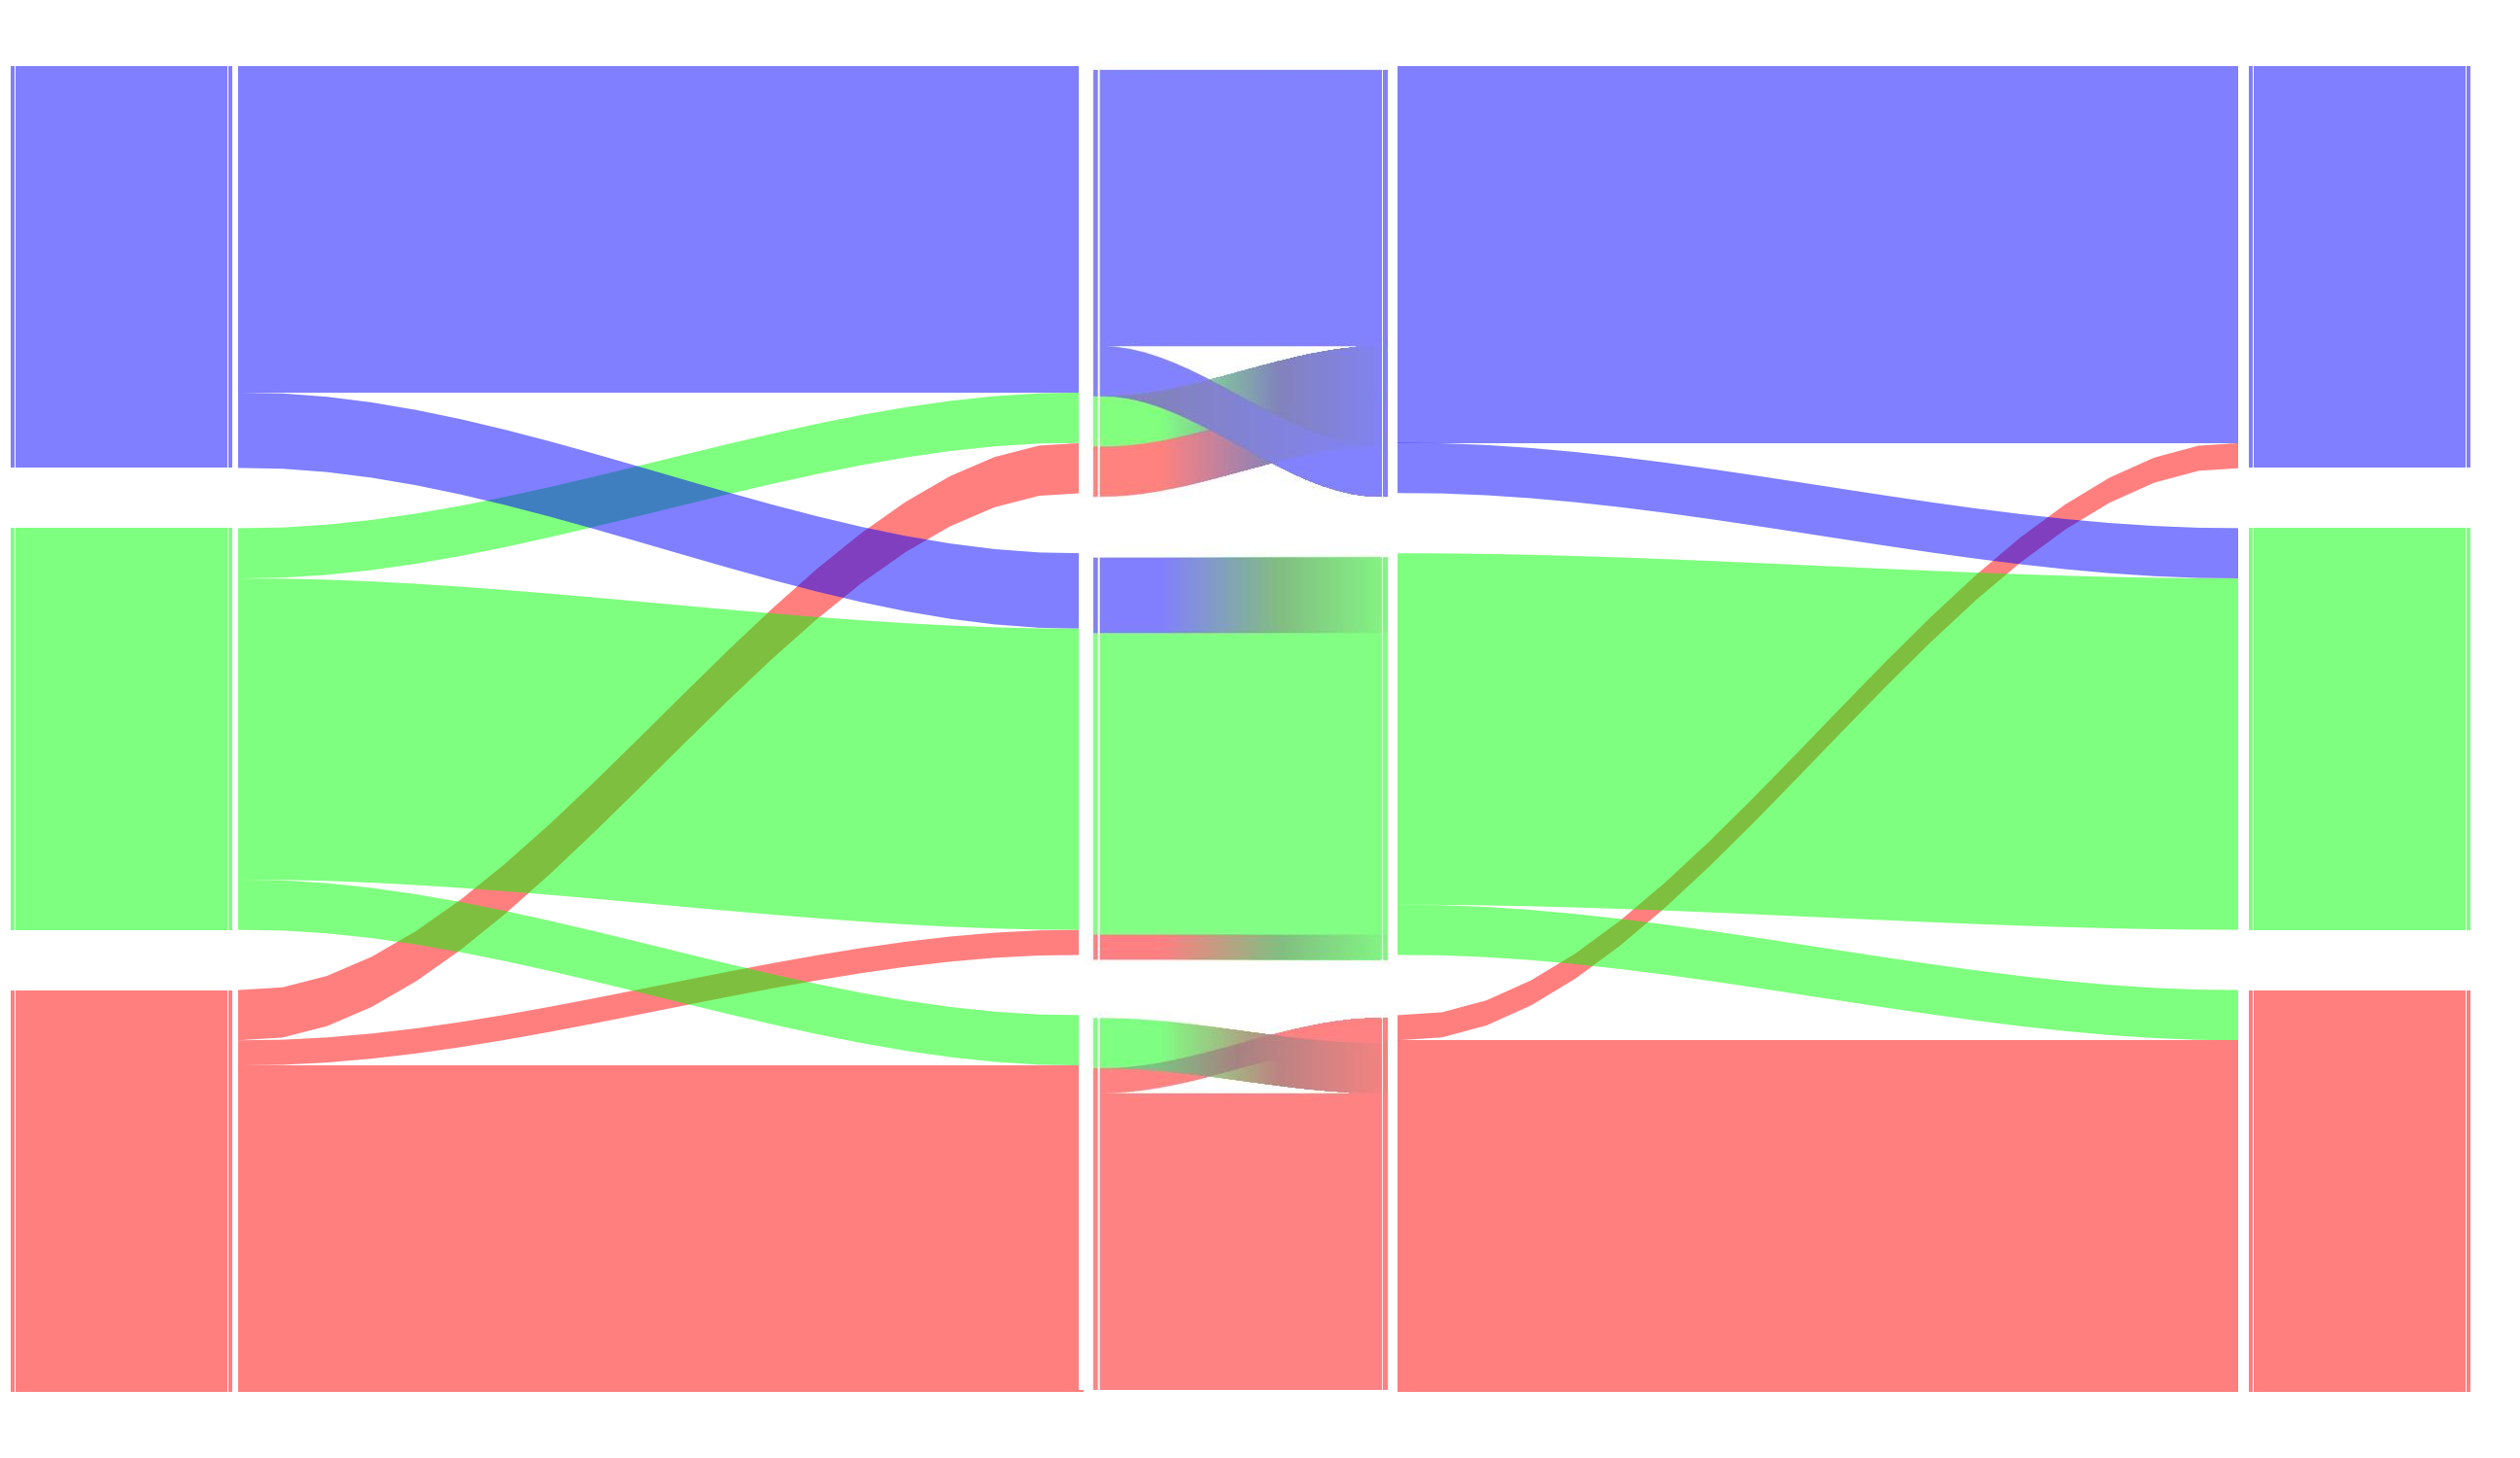

In [39]:
images = [Image.open(x) for x in ['alluvial_T1.png','alluvial12.png', 'intermediate.jpg', 'alluvial23.png','alluvial_T3.png']]

# Crop the first and last images (alluvial plots)
crop_left = 60  # Amount to crop from left
crop_right = 60  # Amount to crop from right
images[1] = images[1].crop((crop_left, 0, images[1].width - crop_right, images[1].height))
images[3] = images[3].crop((crop_left, 0, images[3].width - crop_right, images[3].height))

widths, heights = zip(*(i.size for i in images))
total_width = sum(widths)
max_height = max(heights)

# Create a white background image
new_im = Image.new('RGBA', (total_width, max_height), 'white')

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]-10

new_im.save('composite.png')
display(new_im)
